Cell type part of Undergrad's thesis by Sanghun Jee

In [0]:
import numpy as np
import csv
import sys
import matplotlib.pyplot as plt
import pandas as pd
import tables
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
import seaborn as sns; sns.set()

In [4]:
cd drive/undergrad thesis/mouse_VISp_gene_expression_matrices_2018-06-14

/content/drive/undergrad thesis/mouse_VISp_gene_expression_matrices_2018-06-14


In [0]:
#We will load the exon dataset and sample file
exon_filtered = pd.read_hdf('exon_filtered.h5', key='exon_filtered')
exon_filtered_log2 = np.log2(exon_filtered)
del exon_filtered
samples = pd.read_csv('mouse_VISp_2018-06-14_samples-columns.csv')
exon_filtered_log2[exon_filtered_log2==exon_filtered_log2.values[0, 0]]=0

Let's do cell type(Glutamergic, Gabaergic and etc) classification at first

In [0]:
# Get each cell types indices
Glutamergic_ind = np.where(samples.iloc[:, -6]=='Glutamatergic')[0]
Gabaergic_ind = np.where(samples.iloc[:, -6]=='GABAergic')[0]
Gluta = exon_filtered_log2.iloc[:, Glutamergic_ind]
Gaba = exon_filtered_log2.iloc[:, Gabaergic_ind]

In [0]:
L1_ind = np.where(samples.values[:, 13] =='L1')[0]
L23_ind = np.where(samples.values[:, 13] =='L2/3')[0]
L4_ind = np.where(samples.values[:, 13] =='L4')[0]
L5_ind = np.where(samples.values[:, 13] =='L5')[0]
L6_ind = np.where(samples.values[:, 13] =='L6')[0]

In [0]:
#TO generate all combinations from the set a and b
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

Heatmap

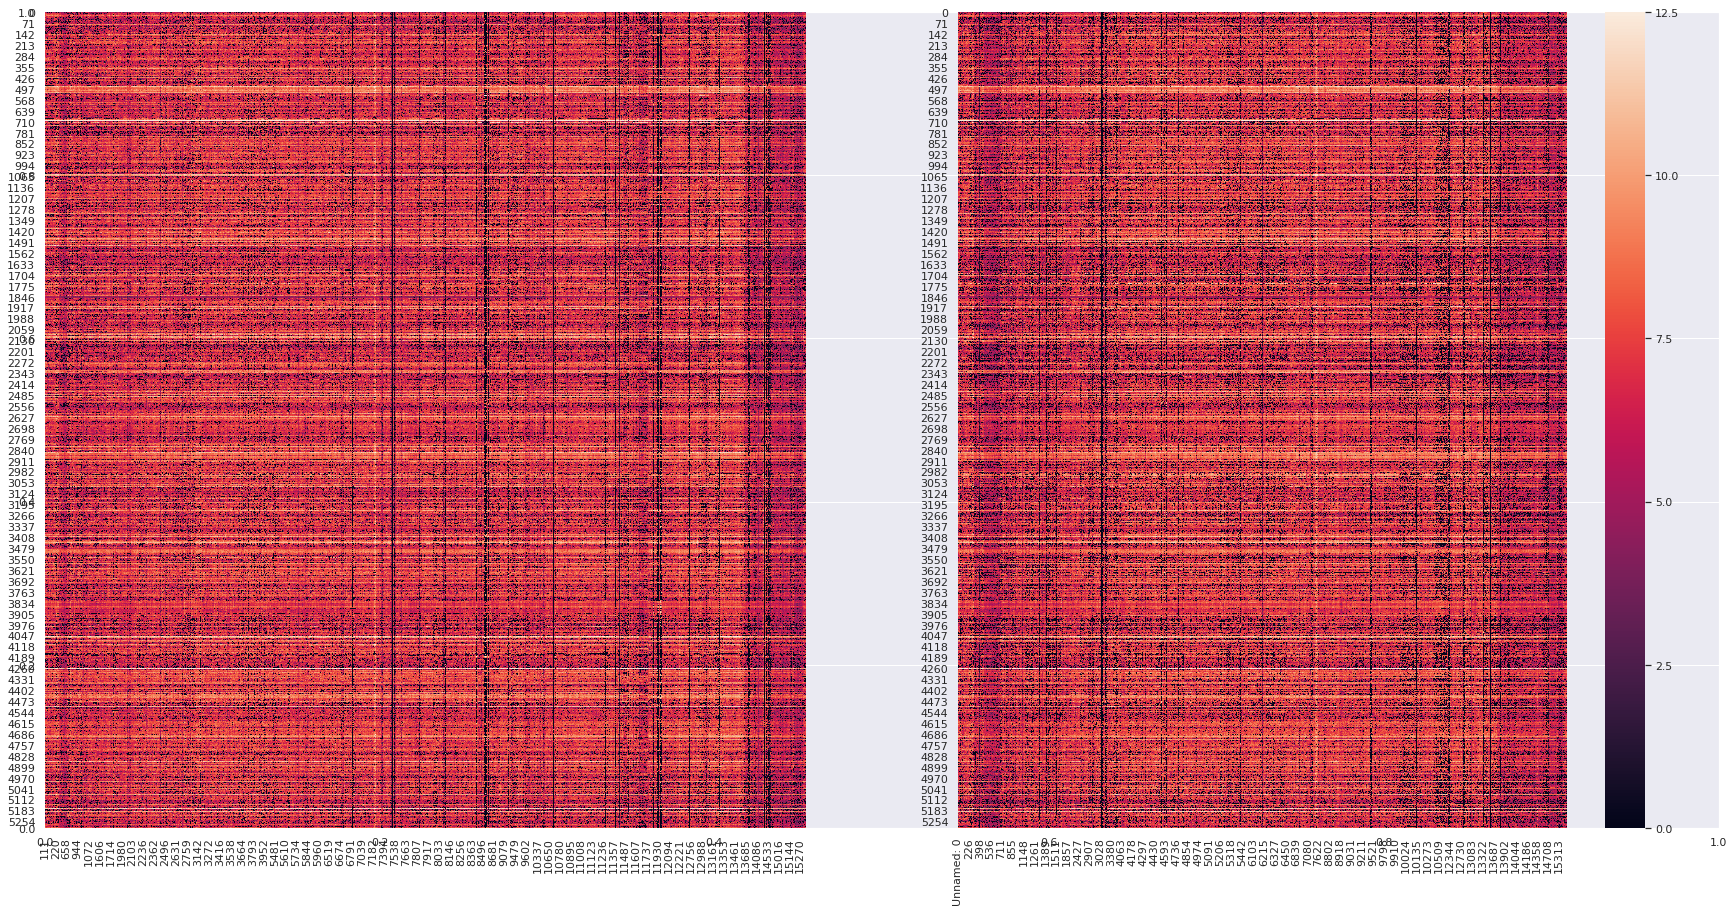

In [0]:
fig, _= plt.subplots(figsize=(30, 15))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = sns.heatmap(Gluta, vmin=0, vmax=12.5, cbar=False) #Glutamergic cell's heatmap

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.heatmap(Gaba, vmin=0, vmax=12.5) # Gabaergic cell's heatmap

fig.savefig('Gluta_Gaba_heatmap.png')

Clustering

In [0]:
#Before do this clustering, I saw the dendrogram and decided the distance threshold to get around 7 clusters
Gluta_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1750).fit(Gluta)
Gaba_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1750).fit(Gaba)

In [0]:
#Get the label. So we know which gene is in which num of cluster
Gluta_label = Gluta_clustering.labels_
Gaba_label = Gaba_clustering.labels_

uniGluta_label = np.unique(Gluta_label)
uniGaba_label = np.unique(Gaba_label)

pre_Gluta = []
pre_Gaba = []
for i in range(0, len(uniGluta_label)):
    pre_Gluta.append(np.where(Gluta_label == uniGluta_label[i]))
    
for i in range(0, len(uniGaba_label)):
    pre_Gaba.append(np.where(Gaba_label == uniGaba_label[i]))
    

In [0]:
#MAke the cell types dataframe 
Gluta_clust = {}
for i in range(0, len(pre_Gluta)):
    Gluta_clust[i] = np.mean(Gluta.values[pre_Gluta[i][0], :], axis=0)
Gluta_clust = pd.DataFrame(Gluta_clust)

Gaba_clust = {}
for i in range(0, len(pre_Gaba)):
    Gaba_clust[i] = np.mean(Gaba.values[pre_Gaba[i][0], :], axis=0)
Gaba_clust = pd.DataFrame(Gaba_clust)

In [0]:
#Get whole possible numbers. This is for statistical test to know which clusters are significant.
from itertools import permutations, product
iter_Gluta = list(permutations(uniGluta_label, 2))
iter_Gaba = list(permutations(uniGaba_label, 2))
total_items = [uniGaba_label, uniGaba_label]
iter_total = list(product(*total_items))

In [0]:
# To make same dimension of sample.
Gluta_shrink = np.random.choice(np.arange(len(Gluta_clust)), size=len(Gaba_clust), replace=False)

In [0]:
#T-test_relative 
p_Gluta, p_Gaba, p_total = [], [], []
for i in iter_Gluta:
    _, p_val = stats.ttest_rel(Gluta_clust.values[:, i[0]], Gluta_clust.values[:, i[1]])
    p_Gluta.append(p_val)
for i in iter_Gaba:
    _, p_val = stats.ttest_rel(Gaba_clust.values[:, i[0]], Gaba_clust.values[:, i[1]])
    p_Gaba.append(p_val)
#for i in iter_total:
#  _, p_val = stats.ttest_rel(Gluta_clust.values[Gluta_shrink, i[0]], Gaba_clust.values[:, i[1]])
#  p_total.append(p_val)

Clusteinrg heatmap 

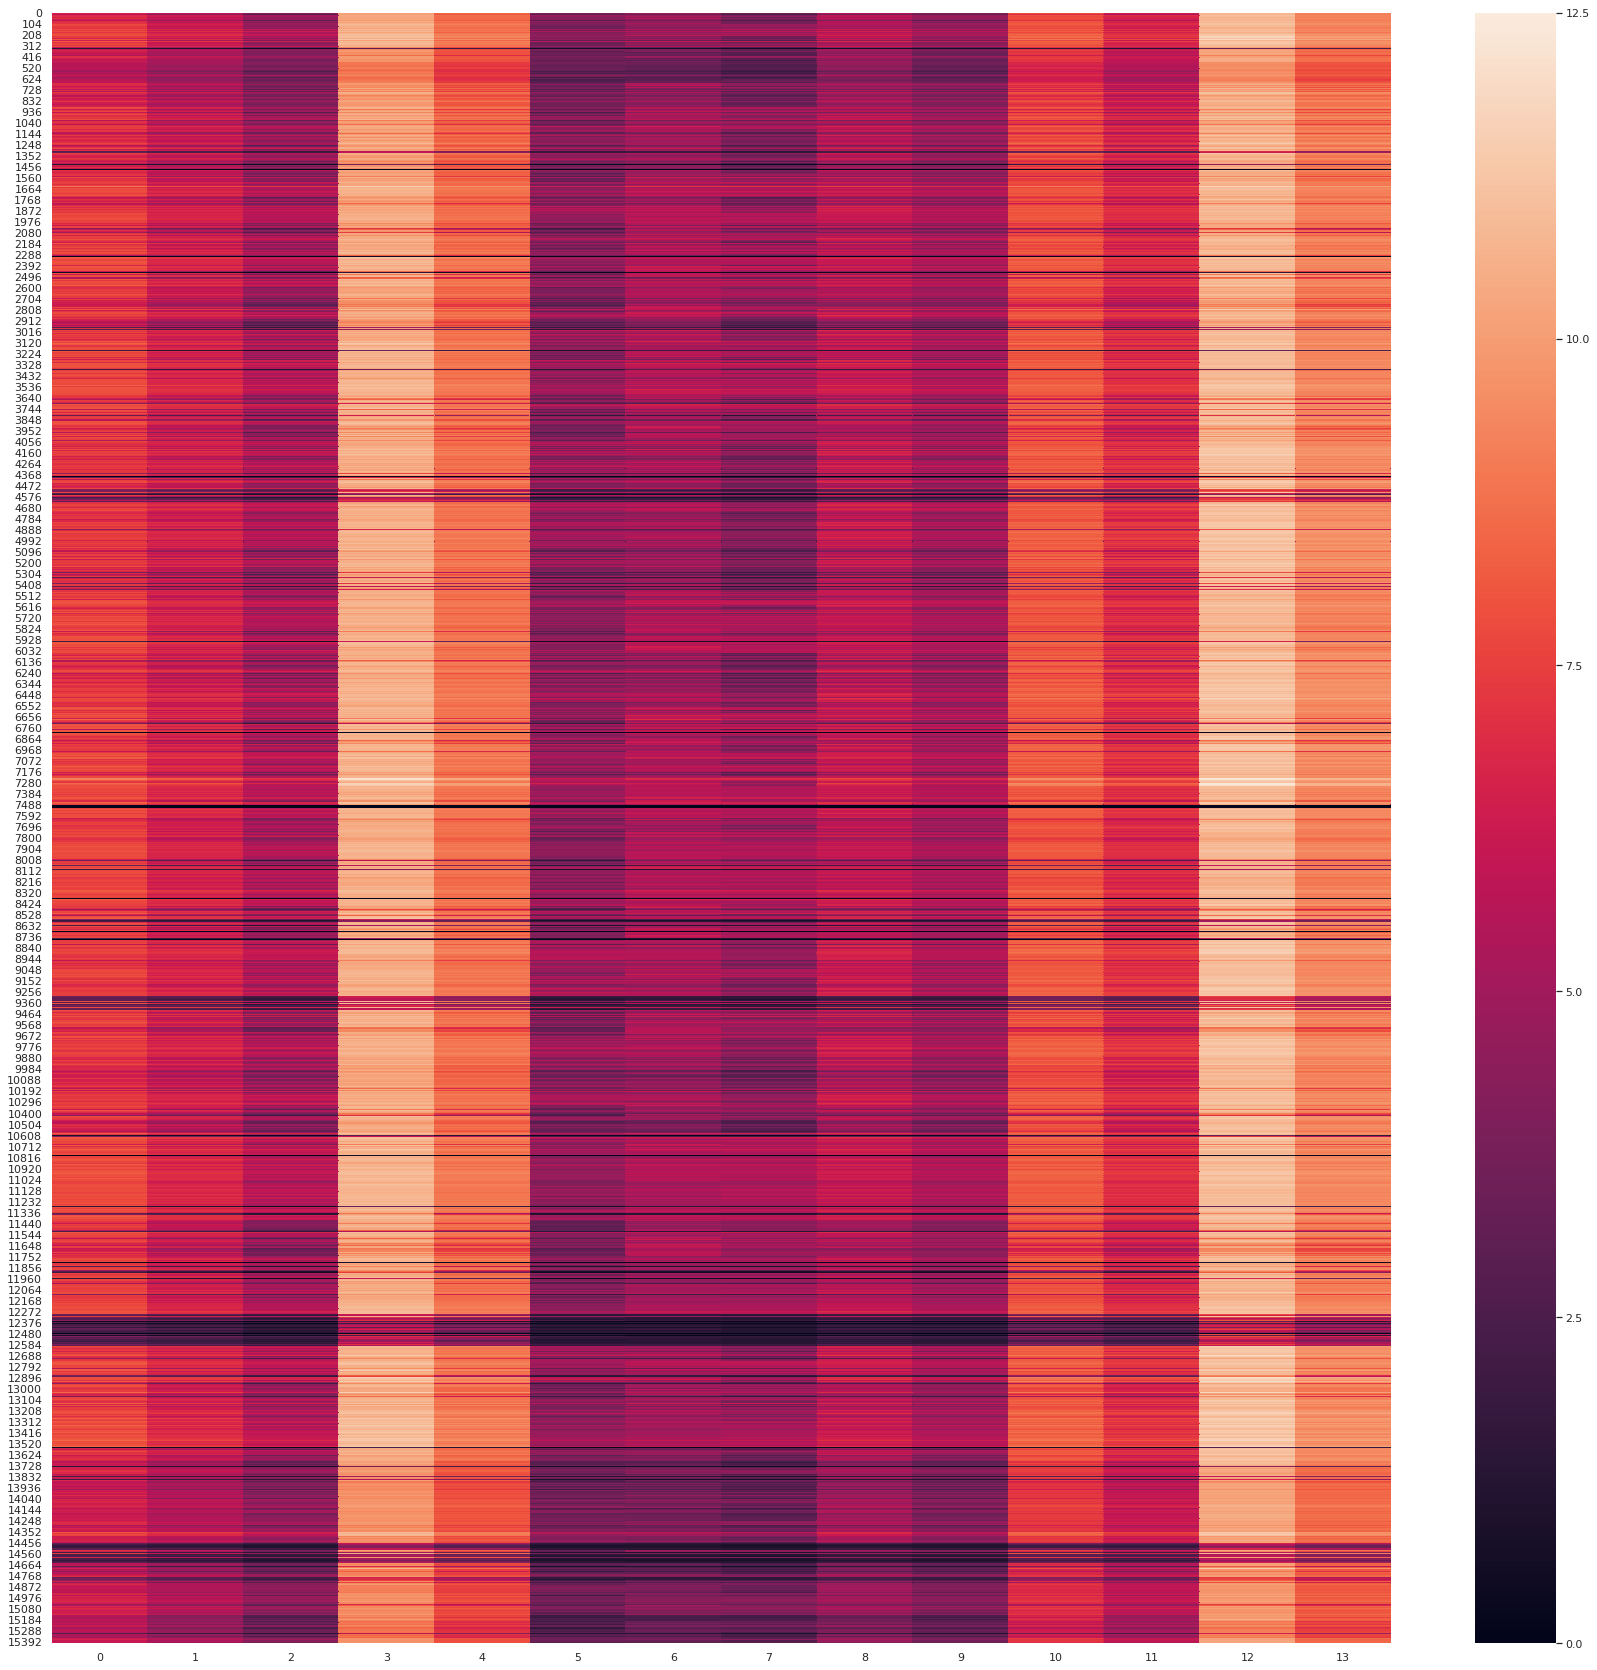

In [0]:
fig1, _ = plt.subplots(figsize=(30, 30))
# ax = fig.add_subplot(1, 2, 1)
# ax = sns.heatmap(Gluta_clust, vmin=0, vmax=12.5)

# ax40 = fig.add_subplot(1, 2, 2)
# ax40 = sns.heatmap(Gaba_clust, vmin=0, vmax=12.5)

# fig1.autoscale(enable=True, axis='x', tight=True)
ax = sns.heatmap(Total_clust, vmin=0, vmax=12.5)
plt.show()

In [0]:
fig1.savefig('celltype_total_clustering[7, :].png')

Let's test it by machin learning

In [0]:
#MAke the cell types dataframe
Gluta_clust_all, Gaba_clust_all = {}, {}
for i in range(0, len(pre_Gluta)):
  Gluta_clust_all[i] = np.mean(exon_filtered_log2.iloc[pre_Gluta[i][0], :], axis=0)
  Gaba_clust_all[i] = np.mean(exon_filtered_log2.iloc[pre_Gaba[i][0], :], axis=0)
Gluta_clust_all = pd.DataFrame(Gluta_clust_all)
Gaba_clust_all = pd.DataFrame(Gaba_clust_all)
Total_clust = pd.DataFrame(np.hstack((Gluta_clust_all, Gaba_clust_all))) #This gonna be X

In [0]:
labels = np.zeros((len(Total_clust))) #So, there are three classes.
labels[Glutamergic_ind] = 1
labels[Gabaergic_ind] = 2

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Total_clust, labels, test_size = .15, train_size = .85)
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

Using TensorFlow backend.


In [0]:
import tensorflow as tf
import keras
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
from keras import layers
from keras import regularizers
from keras import optimizers

In [0]:
model = Sequential()
model.add(Dense(y_train_binary.shape[0], input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(layers.BatchNormalization())
model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
# model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0], activation='sigmoid'))
# model.add(layers.BatchNormalization())
# model.add(Dense(y_train_binary.shape[0]//4, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(y_train_binary.shape[0]//8, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(y_train_binary.shape[0]//16, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(Dropout(0.3))
#model.add(Dense(y_train_binary.shape[0]//16, activation='relu'))
model.add(Dense(y_train_binary.shape[1], activation='softmax'))

Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer= Adam, metrics=['accuracy'])
model.summary()
h = model.fit(X_train, y_train_binary, epochs = 1000, batch_size = X_train.shape[0], verbose=1, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 13102)             196530    
_________________________________________________________________
batch_normalization_5 (Batch (None, 13102)             52408     
_________________________________________________________________
dense_7 (Dense)              (None, 13102)             171675506 
_________________________________________________________________
batch_normalization_6 (Batch (None, 13102)             52408     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 39309     
Total params: 172,016,161
Trainable params: 171,963,753
Non-trainable params: 52,408
_________________________________________________________________
Train on 11791 samples, validate on 1311 samples
Epoch 1/1000
11791/11791 [==============================] - 11s 949us/step

In [0]:
# Ccompare whetehr the model can predict well for test set
pred = model.predict(X_test, batch_size=X_test.shape[0], verbose=1, steps=None)
np.where(pred[0] == np.max(pred[0]))
predict = []
max_label = np.max(pred, axis=1)
for i in range(0, len(max_label)):
  predict.append(np.where(pred[i] == max_label[i]))
predict = np.reshape(predict, (1, -1))[0]
from sklearn.metrics import accuracy_score
accuracy_score(predict, y_test)

In [0]:
#Save the model structure by png file
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:
history = h
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#Let's get the each components
L1_Gluta_ind = list(common_member(Glutamergic_ind, L1_ind))
L23_Gluta_ind = list(common_member(Glutamergic_ind, L23_ind))
L4_Gluta_ind = list(common_member(Glutamergic_ind, L4_ind))
L5_Gluta_ind = list(common_member(Glutamergic_ind, L5_ind))
L6_Gluta_ind = list(common_member(Glutamergic_ind, L6_ind))

L1_Gaba_ind = list(common_member(Gabaergic_ind, L1_ind))
L23_Gaba_ind = list(common_member(Gabaergic_ind, L23_ind))
L4_Gaba_ind = list(common_member(Gabaergic_ind, L4_ind))
L5_Gaba_ind = list(common_member(Gabaergic_ind, L5_ind))
L6_Gaba_ind = list(common_member(Gabaergic_ind, L6_ind))

In [1]:
#Get the each cell type and layers
L1_Gluta = exon_filtered_log2.values[:, L1_Gluta_ind]
L23_Gluta = exon_filtered_log2.values[:, L23_Gluta_ind]
L4_Gluta = exon_filtered_log2.values[:, L4_Gluta_ind]
L5_Gluta = exon_filtered_log2.values[:, L5_Gluta_ind]
L6_Gluta = exon_filtered_log2.values[:, L6_Gluta_ind]

L1_Gaba = exon_filtered_log2.values[:, L1_Gaba_ind]
L23_Gaba = exon_filtered_log2.values[:, L23_Gaba_ind]
L4_Gaba = exon_filtered_log2.values[:, L4_Gaba_ind]
L5_Gaba = exon_filtered_log2.values[:, L5_Gaba_ind]
L6_Gaba = exon_filtered_log2.values[:, L6_Gaba_ind]

NameError: name 'exon_filtered_log2' is not defined

In [0]:
#To get the clustering dendrogram
Z_L1_Gluta_ind = ward(exon_filtered_log2.iloc[:, L1_Gluta_ind])
Z_L23_Gluta_ind = ward(exon_filtered_log2.iloc[:, L23_Gluta_ind])
Z_L4_Gluta_ind = ward(exon_filtered_log2.iloc[:, L4_Gluta_ind])
Z_L5_Gluta_ind = ward(exon_filtered_log2.iloc[:, L5_Gluta_ind])
Z_L6_Gluta_ind = ward(exon_filtered_log2.iloc[:, L6_Gluta_ind])

Z_L1_Gaba_ind = ward(exon_filtered_log2.iloc[:, L1_Gaba_ind])
Z_L23_Gaba_ind = ward(exon_filtered_log2.iloc[:, L23_Gaba_ind])
Z_L4_Gaba_ind = ward(exon_filtered_log2.iloc[:, L4_Gaba_ind])
Z_L5_Gaba_ind = ward(exon_filtered_log2.iloc[:, L5_Gaba_ind])
Z_L6_Gaba_ind = ward(exon_filtered_log2.iloc[:, L6_Gaba_ind])

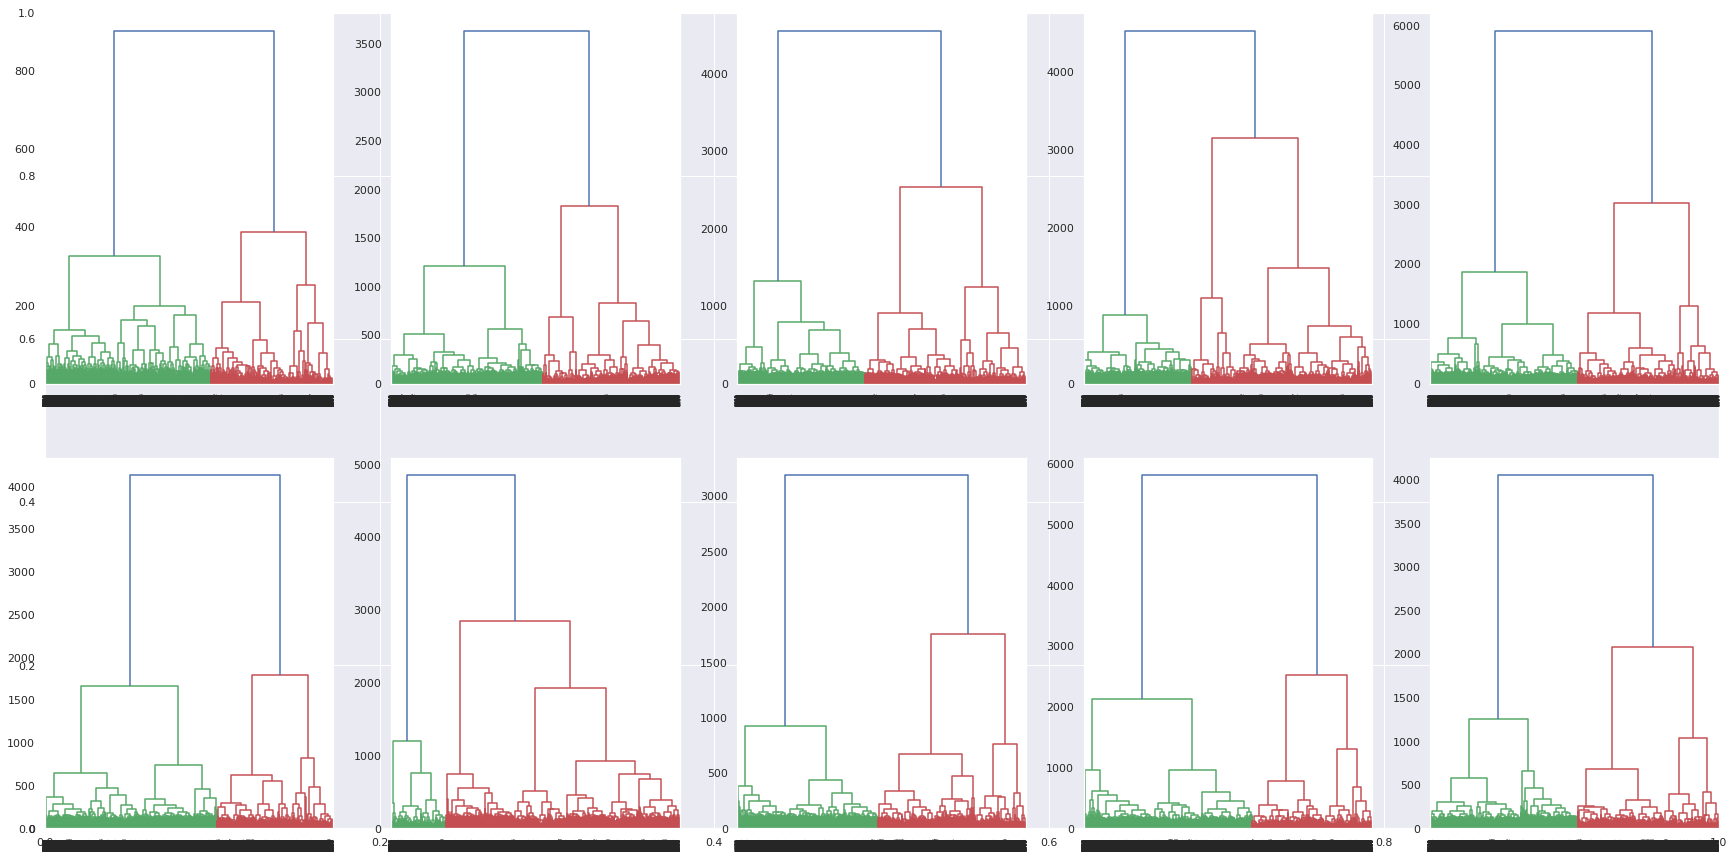

In [0]:
#Clcustering dendrogram
fig, _= plt.subplots(figsize=(30, 15))
ax1 = fig.add_subplot(2, 5, 1)
ax1 = dendrogram(Z_L1_Gluta_ind)

ax2 = fig.add_subplot(2, 5, 2)
ax2 = dendrogram(Z_L23_Gluta_ind)

ax3 = fig.add_subplot(2, 5, 3)
ax3 = dendrogram(Z_L4_Gluta_ind)

ax4 = fig.add_subplot(2, 5, 4)
ax4 = dendrogram(Z_L5_Gluta_ind)

ax5 = fig.add_subplot(2, 5, 5)
ax5 = dendrogram(Z_L6_Gluta_ind)

ax6 = fig.add_subplot(2, 5, 6)
ax6 = dendrogram(Z_L1_Gaba_ind)

ax7 = fig.add_subplot(2, 5, 7)
ax7 = dendrogram(Z_L23_Gaba_ind)

ax8 = fig.add_subplot(2, 5, 8)
ax8 = dendrogram(Z_L4_Gaba_ind)

ax9 = fig.add_subplot(2, 5, 9)
ax9 = dendrogram(Z_L5_Gaba_ind)

ax10 = fig.add_subplot(2, 5, 10)
ax10 = dendrogram(Z_L6_Gaba_ind)

plt.show()

In [0]:
#Clustering
Glu_L1_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=200).fit(L1_Gluta)
Glu_L23_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=500).fit(L23_Gluta)
Glu_L4_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=800).fit(L4_Gluta)
Glu_L5_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=700).fit(L5_Gluta)
Glu_L6_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=900).fit(L6_Gluta)

Gaba_L1_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)
Gaba_L23_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L23_Gaba)
Gaba_L4_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=600).fit(L1_Gaba)
Gaba_L5_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)
Gaba_L6_clust = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=1000).fit(L1_Gaba)

In [0]:
Glu_L1_label = Glu_L1_clust.labels_
Glu_L23_label = Glu_L23_clust.labels_
Glu_L4_label = Glu_L4_clust.labels_
Glu_L5_label = Glu_L5_clust.labels_
Glu_L6_label = Glu_L6_clust.labels_

Gaba_L1_label = Gaba_L1_clust.labels_
Gaba_L23_label = Gaba_L23_clust.labels_
Gaba_L4_label = Gaba_L4_clust.labels_
Gaba_L5_label = Gaba_L5_clust.labels_
Gaba_L6_label = Gaba_L6_clust.labels_

In [ ]:
On going......